First, we import the data

In [1]:
import json

data = json.load(open('wizard_of_wikipedia/data.json'))

## Dataset description

In [2]:
print('Each sample in the dataset has the following keys:')
for key in data[0].keys():
    print('-', key)

Each sample in the dataset has the following keys:
- chosen_topic
- persona
- wizard_eval
- dialog
- chosen_topic_passage


In [4]:
print('Each dialog object contains a list of utterances, \nwhere each utterance is a dictionary with the following keys:')
for key in data[0]['dialog'][0].keys():
    print('-', key)

Each dialog object contains a list of utterances, 
where each utterance is a dictionary with the following keys:
- speaker
- text
- checked_sentence
- checked_passage
- retrieved_passages
- retrieved_topics


In [5]:
print(f'The dataset contains {len(data)} documents.')

The dataset contains 22311 documents.


In [6]:
import nltk

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

dialogues = []

for document in data:
    dialogue = {}
    dialogue['topic'] = document['chosen_topic']
    dialogue['sentences_tokenized'] = []
    dialogue['starting_speaker'] = document['dialog'][0]['speaker']
    for utterance in document['dialog']:
        tokenized = tokenizer.tokenize(utterance['text'])
        # To lower case
        tokenized = [token.lower() for token in tokenized]
        dialogue['sentences_tokenized'].append(tokenized)
    dialogues.append(dialogue)

In [7]:
print('The "dialogues" object is a list of dictionaries, \nwhere each dictionary represents a dialogue and has the following keys:')
for key in dialogues[0].keys():
    print('-', key)
print('where "sentences_tokenized" is a list of lists, \nwhere each list represents a sentence and contains the tokens of that sentence.')

The "dialogues" object is a list of dictionaries, 
where each dictionary represents a dialogue and has the following keys:
- topic
- sentences_tokenized
- starting_speaker
where "sentences_tokenized" is a list of lists, 
where each list represents a sentence and contains the tokens of that sentence.


In [8]:
avg_doc_length = sum([len(dialogue['sentences_tokenized']) for dialogue in dialogues]) / len(dialogues)
print(f'The average document length is {avg_doc_length} sentences.')

The average document length is 9.053785128411993 sentences.


In [9]:
avg_sentence_length = sum([len(sentence) for dialogue in dialogues for sentence in dialogue['sentences_tokenized']]) / sum([len(dialogue['sentences_tokenized']) for dialogue in dialogues])
print(f'The average sentence length is {avg_sentence_length} tokens.')

The average sentence length is 16.73698879697424 tokens.


In [10]:
avg_vocabulary_size = sum([len(set([token for sentence in dialogue['sentences_tokenized'] for token in sentence])) for dialogue in dialogues]) / len(dialogues)
print(f'The average vocabulary size is {avg_vocabulary_size} tokens.')

The average vocabulary size is 93.67500336157053 tokens.


In [11]:
dataset_vocabulary_size = len(set([token for dialogue in dialogues for sentence in dialogue['sentences_tokenized'] for token in sentence]))
print(f'The dataset vocabulary size is {dataset_vocabulary_size} tokens.')

The dataset vocabulary size is 47189 tokens.


In [12]:
n_topics = len(set([dialogue['topic'] for dialogue in dialogues]))
print(f'The dataset contains {n_topics} topics.')

The dataset contains 1365 topics.


In [13]:
# Train a word2vec model
from gensim.models import Word2Vec

model = Word2Vec([sentence for dialogue in dialogues for sentence in dialogue['sentences_tokenized']], min_count=1, vector_size=100, workers=4)

In [14]:
# Get the vocabulary
vocabulary = list(model.wv.key_to_index.keys())

# Get the word embeddings
word_embeddings = model.wv[vocabulary]

# Get the word embedding for a specific word
print('The word embedding for the word "computer" is:')
print(model.wv['computer'])

The word embedding for the word "computer" is:
[-1.4873731   0.8424639   1.3941711   0.46361777 -0.5246708  -0.30799314
 -0.41369164  0.6743244  -0.19172312 -1.5345781  -0.29504395  0.14164947
  1.2148306   0.53679127 -0.94219685 -0.23739818 -0.4508786  -0.42135972
  0.6052402   0.04470804  0.601827   -1.0090344   0.8803488  -0.44512412
  0.15612496 -0.18229558 -0.6673681  -0.21400973  0.14428079 -1.02326
 -1.1468217   1.5500023  -1.2821006   0.9438027  -0.5426114   0.06920392
  1.2341808  -0.6288502   0.31579554 -0.2897613   0.35241395  0.06803215
 -0.10662405  0.2356671   0.0653685  -1.1049448  -1.0930746  -0.41645655
  0.6413274   1.0483428   0.06417513  0.32905757 -0.5389928  -0.71701413
 -0.03600844  0.830072    1.844559    0.68879104 -0.4808267   0.42278984
  1.4950095  -0.1911311  -0.7396302  -0.29433575 -0.13843699 -1.2553684
 -1.6186395   0.06045576  0.50624686  0.1583618  -0.42597514  0.22017424
  0.8557255  -0.8136301   0.44007576  0.00395099  0.78775597 -0.5595751
 -0.03202

In [15]:
import numpy as np

def dialogue_embed(dialogue):
    dialogue_embedding = np.zeros(100)
    for sentence in dialogue['sentences_tokenized']:
        for token in sentence:
            dialogue_embedding += model.wv[token]
    dialogue_embedding /= sum([len(sentence) for sentence in dialogue['sentences_tokenized']])
    return dialogue_embedding

dialogue_embeddings = [dialogue_embed(dialogue) for dialogue in dialogues]

In [16]:
dialogue_embeddings = np.array(dialogue_embeddings)
dialogue_embeddings.shape

(22311, 100)

In [17]:
# Train a k-means clustering model
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_topics).fit(dialogue_embeddings)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_cluster(highlight, normal, dialogues, k, title):
    if highlight.shape[1] != normal.shape[1]:
        print('Error in the dimensions of the data. Shape of data must be coherent.')
    if highlight.shape[1] == 3:
        # Make a 3d plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(normal[:, 0], normal[:, 1], normal[:, 2], c='b', alpha=0.01)
        ax.scatter(highlight[:, 0], highlight[:, 1], highlight[:, 2], c='r', alpha=1)
    if highlight.shape[1] == 2:
        plt.figure(figsize=(10, 10))
        plt.scatter(normal[:, 0], normal[:, 1], c='b', alpha=0.05)
        plt.scatter(highlight[:, 0], highlight[:, 1], c='r', alpha=1)
    else:
        print('Error in the dimensions of the data. Shape must be 2 or 3.')
    plt.title(title)
    plt.show()
    print(nltk.Counter([dialogues[i]['topic'] for i in range(len(dialogues)) if cluster_labels[i] == k]))

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pca_2d = PCA(n_components=2)
# pca_2d.fit(dialogue_embeddings)
# dialogue_embeddings_2d = pca_2d.transform(dialogue_embeddings)

In [21]:
import pickle

# Dump
# pickle.dump(dialogue_embeddings_2d, open('dumps/clustering/pca_2d.pkl', 'wb'))

dialogue_embeddings_2d = pickle.load(open('dumps/clustering/pca_2d.pkl', 'rb'))

In [22]:
# pca_3d = PCA(n_components=3)
# pca_3d.fit(dialogue_embeddings)
# dialogue_embeddings_3d = pca_3d.transform(dialogue_embeddings)

In [23]:
# Dump
# pickle.dump(dialogue_embeddings_3d, open('dumps/clustering/pca_3d.pkl', 'wb'))

dialogue_embeddings_3d = pickle.load(open('dumps/clustering/pca_3d.pkl', 'rb'))

In [24]:
# tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
# dialogue_embeddings_2d_tsne = tsne_2d.fit_transform(dialogue_embeddings)

In [25]:
# Dump
# pickle.dump(dialogue_embeddings_2d_tsne, open('dumps/clustering/tsne_2d.pkl', 'wb'))

dialogue_embeddings_2d_tsne = pickle.load(open('dumps/clustering/tsne_2d.pkl', 'rb'))

In [26]:
# tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, verbose=1)
# dialogue_embeddings_3d_tsne = tsne_3d.fit_transform(dialogue_embeddings)

In [27]:
# Dump
# pickle.dump(dialogue_embeddings_3d_tsne, open('dumps/clustering/tsne_3d.pkl', 'wb'))

dialogue_embeddings_3d_tsne = pickle.load(open('dumps/clustering/tsne_3d.pkl', 'rb'))

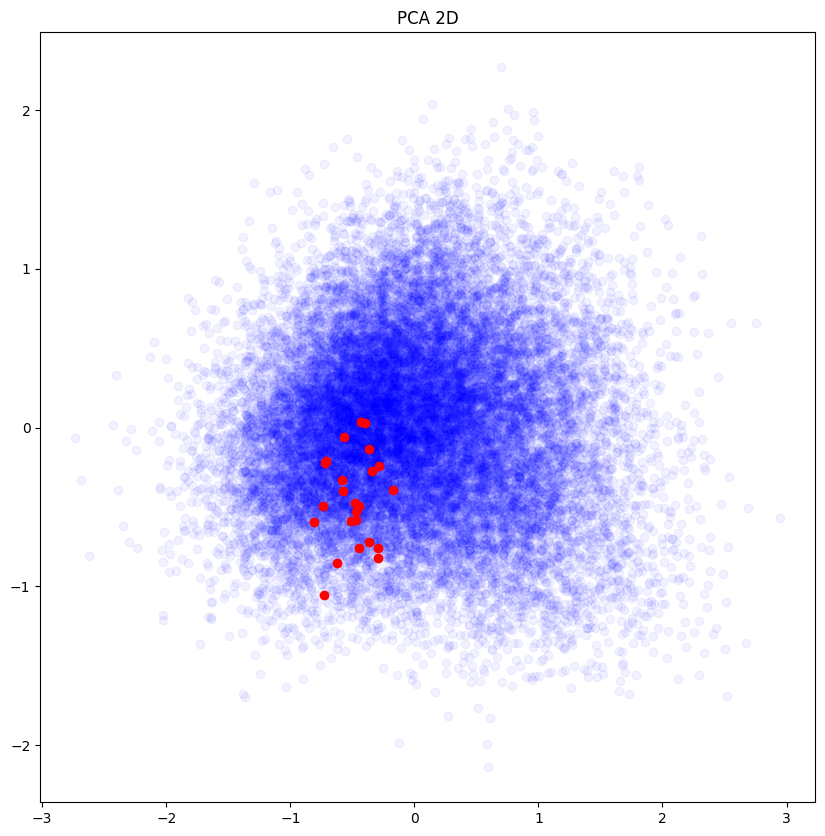

Counter({'Cat': 6, 'Dog': 5, 'German Shepherd': 2, 'Pug': 2, 'Golden Retriever': 2, 'Cat people and dog people': 2, 'Husky': 1, 'Parrot': 1, 'French Bulldog': 1, 'Beagle': 1, 'Goldendoodle': 1})
Error in the dimensions of the data. Shape must be 2 or 3.


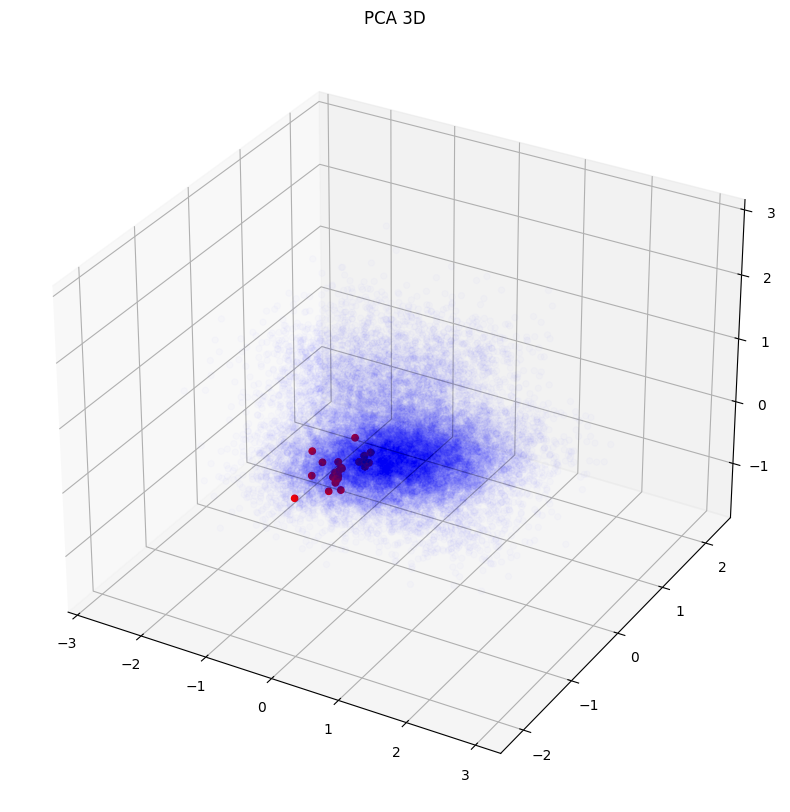

Counter({'Cat': 6, 'Dog': 5, 'German Shepherd': 2, 'Pug': 2, 'Golden Retriever': 2, 'Cat people and dog people': 2, 'Husky': 1, 'Parrot': 1, 'French Bulldog': 1, 'Beagle': 1, 'Goldendoodle': 1})


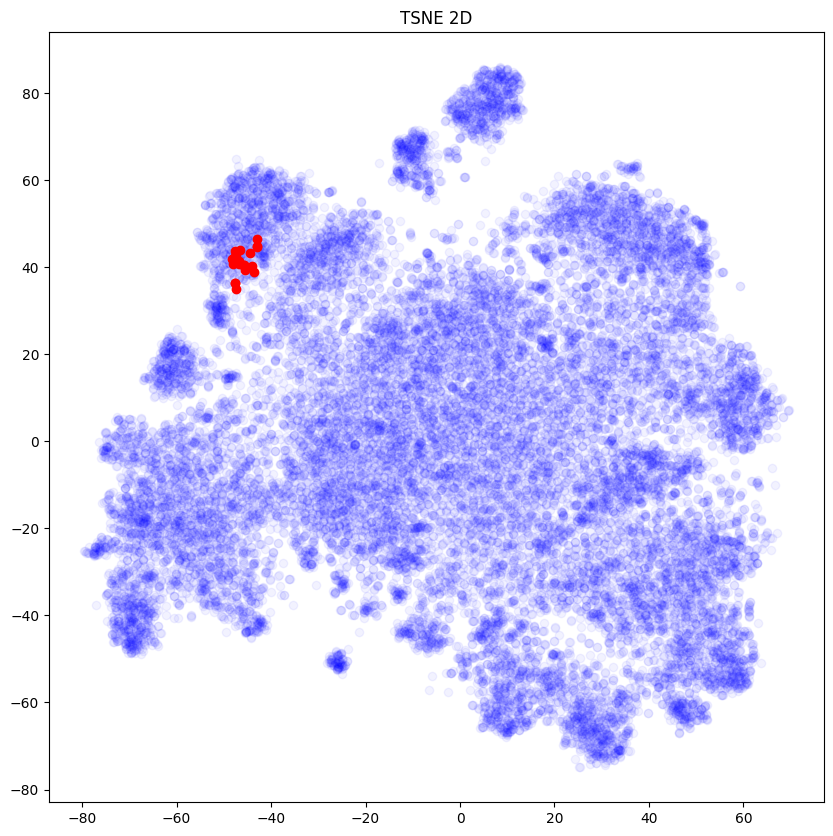

Counter({'Cat': 6, 'Dog': 5, 'German Shepherd': 2, 'Pug': 2, 'Golden Retriever': 2, 'Cat people and dog people': 2, 'Husky': 1, 'Parrot': 1, 'French Bulldog': 1, 'Beagle': 1, 'Goldendoodle': 1})
Error in the dimensions of the data. Shape must be 2 or 3.


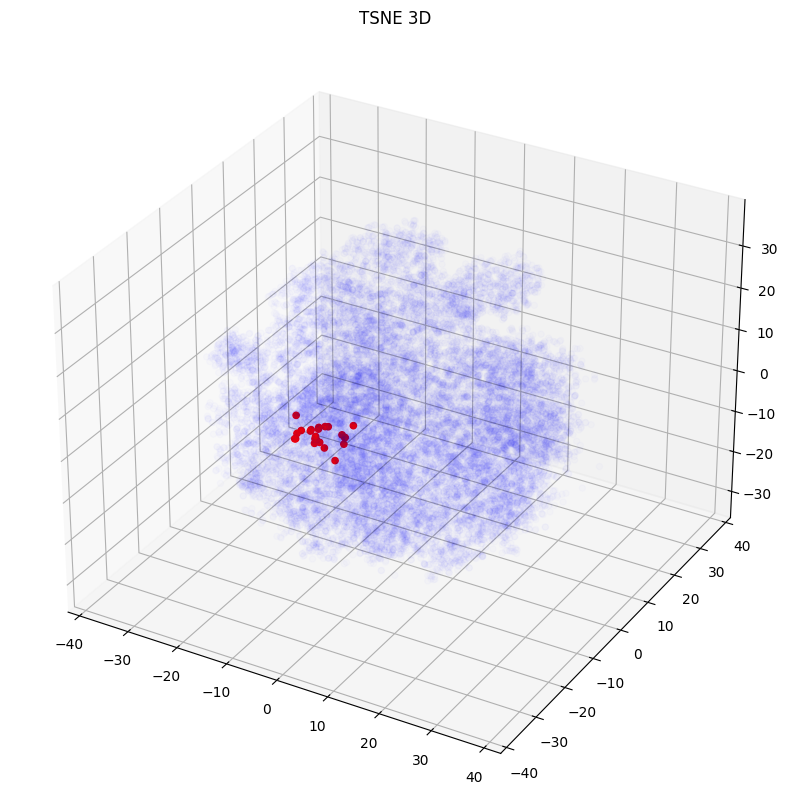

Counter({'Cat': 6, 'Dog': 5, 'German Shepherd': 2, 'Pug': 2, 'Golden Retriever': 2, 'Cat people and dog people': 2, 'Husky': 1, 'Parrot': 1, 'French Bulldog': 1, 'Beagle': 1, 'Goldendoodle': 1})


In [54]:
k = 818

visualize_cluster(dialogue_embeddings_2d[cluster_labels == k], dialogue_embeddings_2d[cluster_labels != k], dialogues, k, 'PCA 2D')
visualize_cluster(dialogue_embeddings_3d[cluster_labels == k], dialogue_embeddings_3d[cluster_labels != k], dialogues, k, 'PCA 3D')
visualize_cluster(dialogue_embeddings_2d_tsne[cluster_labels == k], dialogue_embeddings_2d_tsne[cluster_labels != k], dialogues, k, 'TSNE 2D')
visualize_cluster(dialogue_embeddings_3d_tsne[cluster_labels == k], dialogue_embeddings_3d_tsne[cluster_labels != k], dialogues, k, 'TSNE 3D')